In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle
from shapely.geometry import Point
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.ticker import FuncFormatter, FixedLocator

In [2]:
# import the previously saved stations data to the notebook

NO3_N_dfs_filtered = None
with open("NO3_N_dfs_filtered", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    NO3_N_dfs_filtered = pickle.load(file)

In [3]:
thresh = 2         # only consider data for minimum thresh years
stations_after_thresh = [df for i,df in enumerate(NO3_N_dfs_filtered) if len(df.iloc[:,1].unique()) > thresh]
print("Number of stations after applying minimum years threshold = ", len(stations_after_thresh))

Number of stations after applying minimum years threshold =  500


In [4]:
# combine data for all months and all stations in a matrix

monthly_conc = np.empty((12,len(stations_after_thresh)), dtype=float)
easting_values = []
northing_values = []
for station,df in enumerate(stations_after_thresh):
    easting_values.append(df.iloc[0,5])
    northing_values.append(df.iloc[0,6])
    for month in range(12):
        if df.loc[df.iloc[:, 2] == (month+1), df.columns[0]].shape[0] == 0:
            monthly_conc[month, station] = 0
        else:
            conc_mean = np.mean(np.array(df.loc[df.iloc[:, 2] == (month+1), df.columns[0]]))
            monthly_conc[month, station] = conc_mean

In [5]:
all_conc = monthly_conc.flatten()

In [6]:
# check the data
df = stations_after_thresh[300]
print(np.mean(np.array(df.loc[df.iloc[:, 2] == 5, df.columns[0]])))
df

0.73175


,NO3-N [mg/l],year,month,date,year_month,easting,northing,station_name,station_number,water_body,NO3-N [mg/l] BC
0,0.881,2014,1,2014-01-14,2014-01,695988.0,5341134.0,Unterföhring,10952,Mittlere-Isar-Kanal,-0.123544
1,0.972,2014,2,2014-02-03,2014-02,695988.0,5341134.0,Unterföhring,10952,Mittlere-Isar-Kanal,-0.028239
2,0.994,2014,3,2014-03-05,2014-03,695988.0,5341134.0,Unterföhring,10952,Mittlere-Isar-Kanal,-0.006011
3,0.791,2014,4,2014-04-07,2014-04,695988.0,5341134.0,Unterföhring,10952,Mittlere-Isar-Kanal,-0.223811
4,0.791,2014,5,2014-05-08,2014-05,695988.0,5341134.0,Unterföhring,10952,Mittlere-Isar-Kanal,-0.223811
...,...,...,...,...,...,...,...,...,...,...,...
93,0.723,2021,8,2021-08-23,2021-08,695988.0,5341134.0,Unterföhring,10952,Mittlere-Isar-Kanal,-0.304209
94,0.678,2021,9,2021-09-28,2021-09,695988.0,5341134.0,Unterföhring,10952,Mittlere-Isar-Kanal,-0.359942
95,0.791,2021,10,2021-10-19,2021-10,695988.0,5341134.0,Unterföhring,10952,Mittlere-Isar-Kanal,-0.223811
96,0.814,2021,11,2021-11-22,2021-11,695988.0,5341134.0,Unterföhring,10952,Mittlere-Isar-Kanal,-0.197561


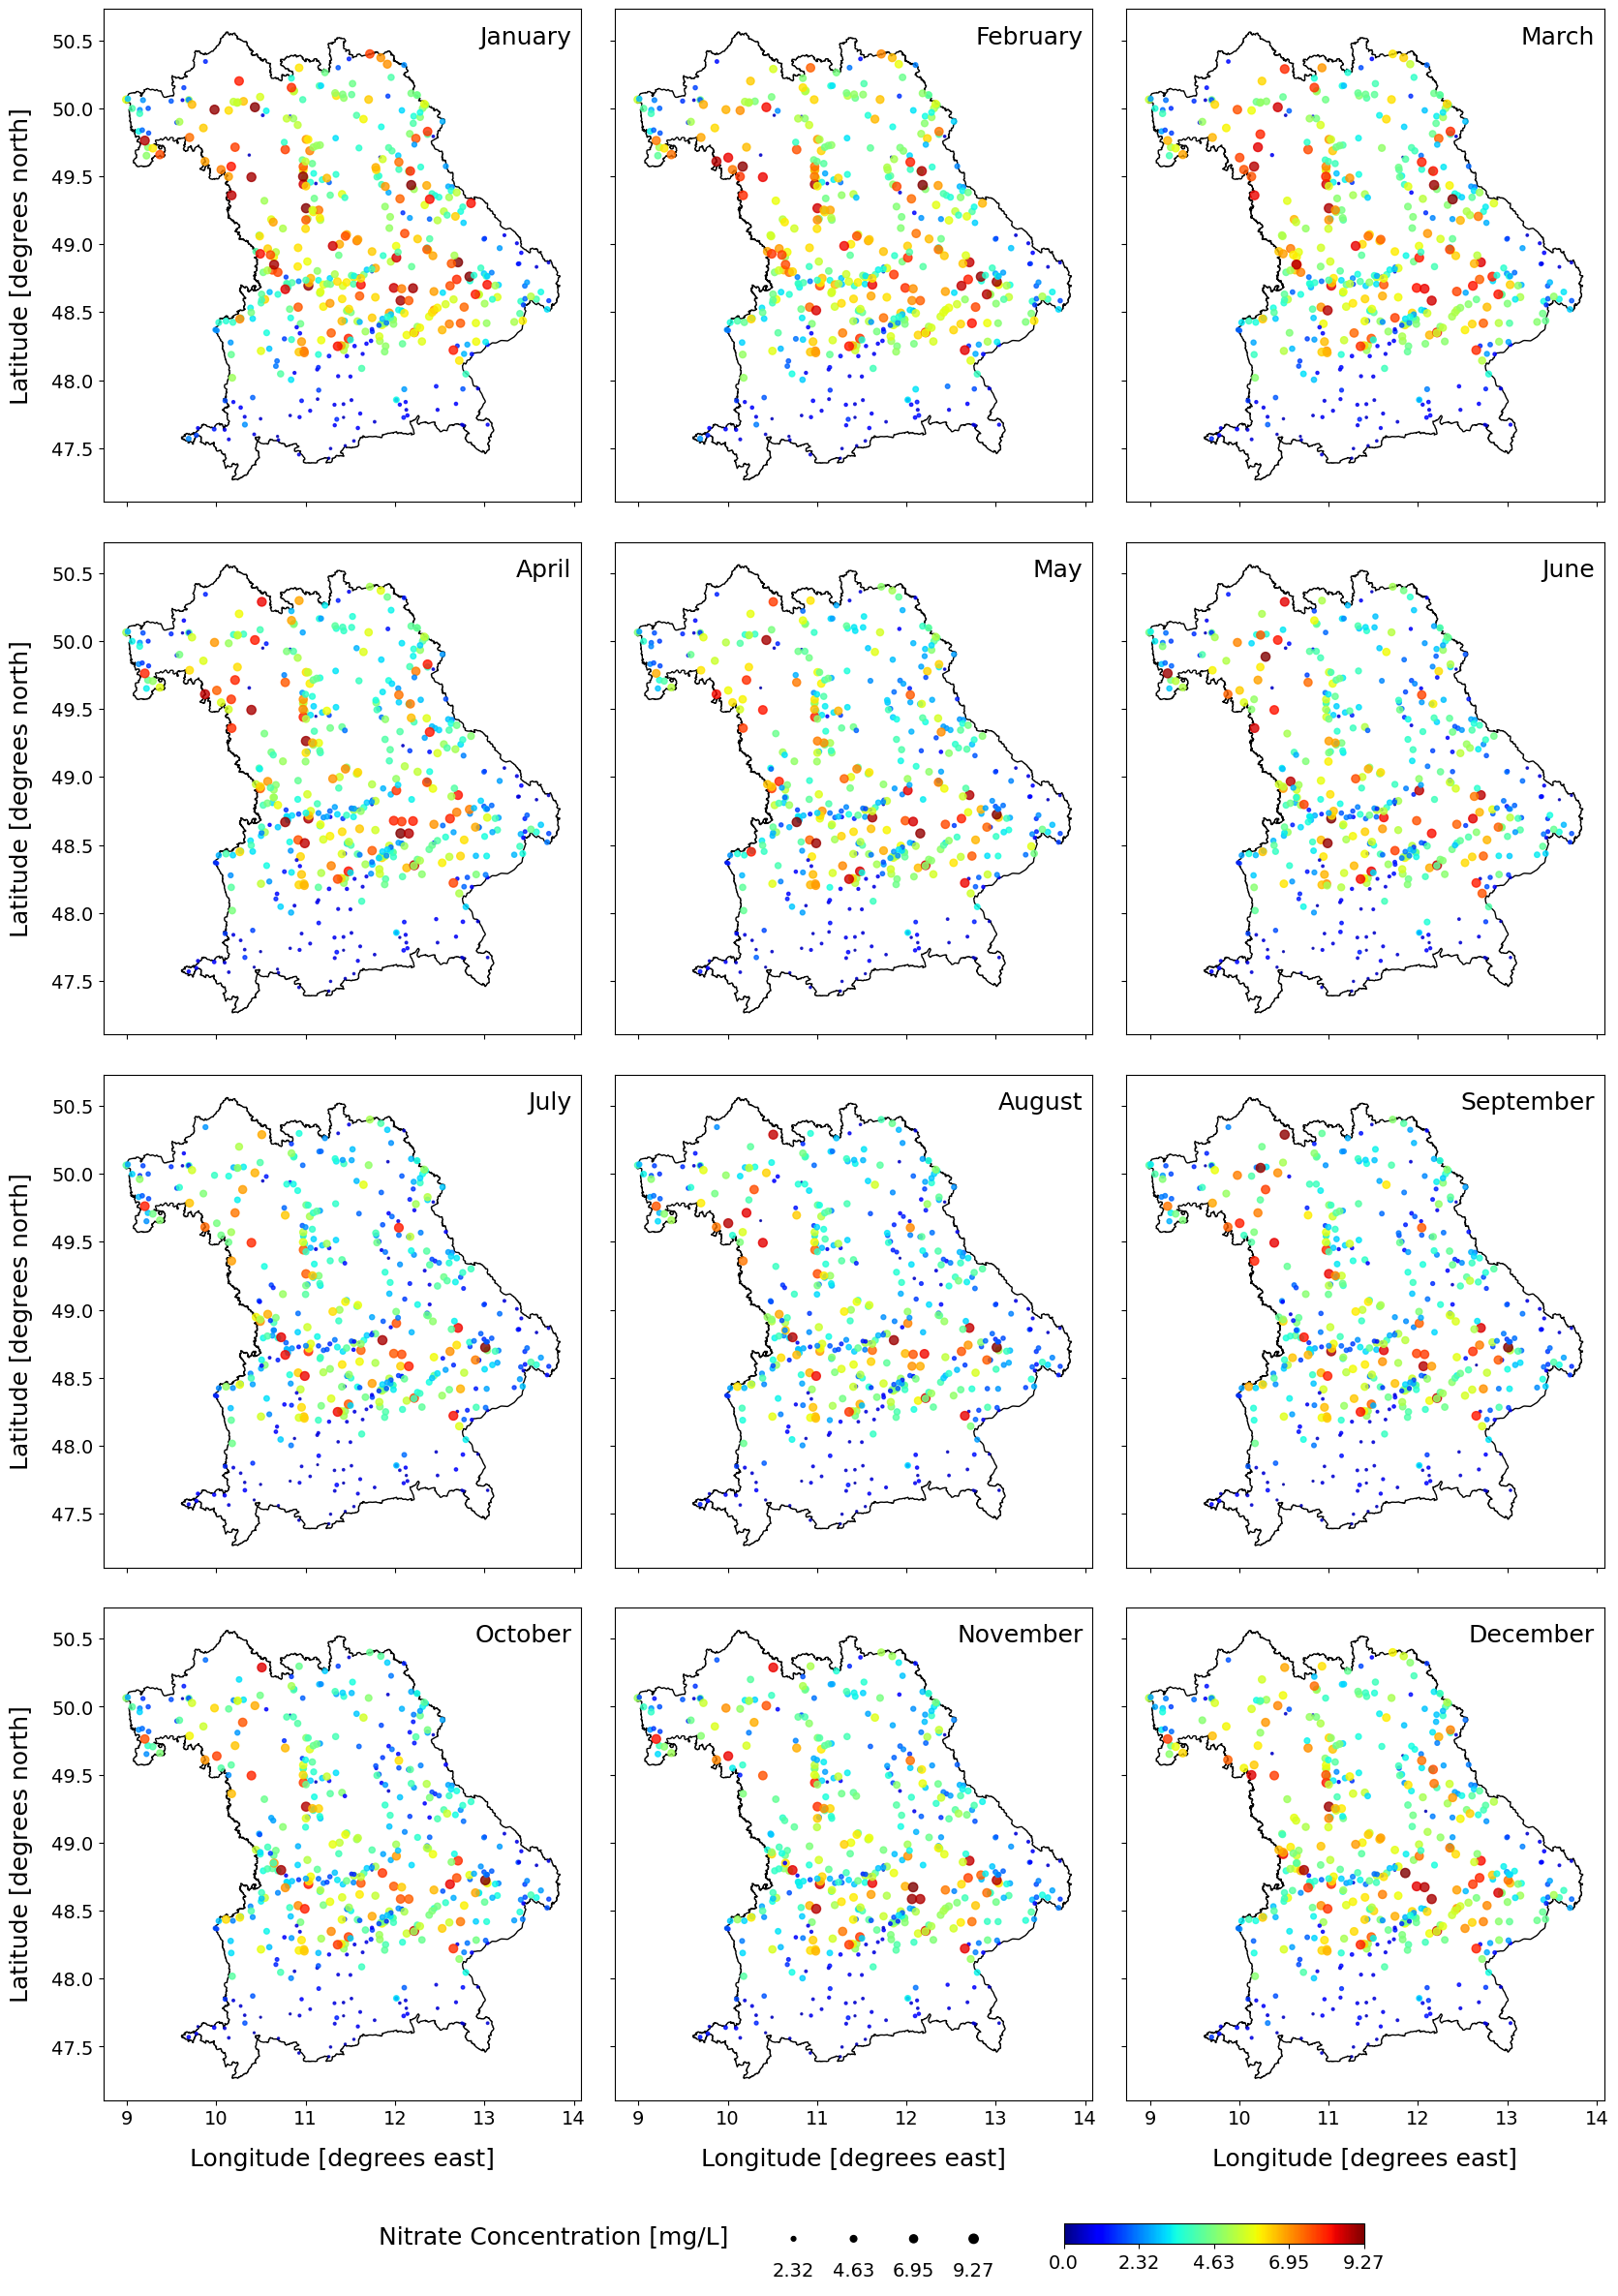

In [11]:
# figure to use in publication
# Create subplots for all the months


row_dict = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 4, 13: 4, 14: 4}  # storing row indices for subplot in a dictionary
col_dict = {0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 2, 6: 0, 7: 1, 8: 2, 9: 0, 10: 1, 11: 2, 12: 0, 13: 1, 14: 2}  # storing column indices for subplot in a dictionary
label_dict = {0: 'January', 1: 'February', 2: 'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July', 7: 'August', 8: 'September', 9: 'October', 10: 'November', 11: 'December'}  # storing labels for subplot in a dictionary
geometry = gpd.points_from_xy(easting_values, northing_values)
norm = plt.Normalize(vmin=all_conc.min(), vmax=all_conc.max())

# Load Bavaria shapefile
bavaria = gpd.read_file(r"J:\study_project\geoBoundaries-DEU-ADM1-all\bavaria_outline.shp", crs='epsg:25832')
bavaria = bavaria.to_crs('EPSG:4326')

fig = plt.figure(figsize=(20, 30))
grid = plt.GridSpec(5, 3, wspace = 0.07,hspace = 0.01, height_ratios=[10,10,10,10,2])

for i in range(13):
# If i is less than 12, then we plot the subplots for available data. If i is 12, we plot the last row of subplot grid and combine all 3 of its columns into a single row. 
# The colorbar and the size legend is then plotted in this last subplot and the borders are then removed.            
    if i < 12:    

        ax = fig.add_subplot(grid[row_dict[i], col_dict[i]])
        stations_gdf = gpd.GeoDataFrame({'Concentration': monthly_conc[i,:]}, geometry=geometry, crs='epsg:25832')
        stations_gdf = stations_gdf.to_crs('EPSG:4326')
        bavaria.plot(ax=ax, color='white', edgecolor='black')
        sc = ax.scatter(stations_gdf.geometry.x, stations_gdf.geometry.y, c=norm(stations_gdf['Concentration']), cmap='jet', s=stations_gdf['Concentration']*5, alpha=0.8)
        
        ax.text(0.98, 0.93, label_dict[i], transform = ax.transAxes, size = 18,ha='right')
        
        # only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
        if i in range(9,12):
            
            ax.set_xlabel('Longitude [degrees east]', fontsize = 18, labelpad = 14)

        
        # only add y label for the first column of subplot    
        if i in range(0,10,3):
            
            ax.set_ylabel('Latitude [degrees north]', fontsize = 18, labelpad = 14)

            
        if i not in range(9,12):
            ax.set_xticklabels([])
        
        
        if i not in range(0,10,3): 
            ax.set_yticklabels([])

        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
    
    else:
        # plot the legend in the last row of subplot and combine all the columns
        cbar_ax = fig.add_subplot(grid[row_dict[i], :])
        
# manually adjust the positions of the subplots and the color bar
for ax in fig.axes[:-1]:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])      


# insert the colorbar as an axes in the last row of subplot grid. this row was reserved for legend and has no data. 
cax = cbar_ax.inset_axes([0.64, 0.4,0.2, 0.2], transform=cbar_ax.transAxes) # [left, bottom, width, height] 
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), cax=cax, orientation='horizontal')
ticks = np.linspace(all_conc.min(), all_conc.max(), 5)
cbar.set_ticks(ticks) # the colorbar represents the normalized data by default so add ticks manually
cbar.set_ticklabels(np.around(np.linspace(all_conc.min(),all_conc.max() , 5), decimals = 2), fontsize=14 )
#cbar.set_ticklabels(ticks, fontsize=14)

# Size legend plotting

x_pos = [0.46, 0.50, 0.54, 0.58] # x location to create points representing size of plotted data
size_labels = [2.32, 4.63, 6.95, 9.27] # size of the points representing different size of plotted data
cbar_ax.text(0.30, 0.4, "Nitrate Concentration [mg/L]", fontsize=18, ha="center", transform=cbar_ax.transAxes)

# Place text below the plotted points
for (xpos, label) in zip(x_pos, size_labels):
    cbar_ax.text(xpos, 0.1,  f"{label}", fontsize=14, ha="center", transform= cbar_ax.transAxes)
    
# plot points representing size of plotted data    
cbar_ax.scatter( x_pos, [0.45]*4, s=(np.array(size_labels))*5, color="black",transform=cbar_ax.transAxes)

# remove boundaries of the last row of subplot grid
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)

plt.savefig('stations_monthly_concentration.svg', format = 'svg', bbox_inches = 'tight')

In [31]:
# check which stations in January have high concentrations

check_conc = []
for i in range(len(stations_after_thresh)):
    if monthly_conc[0,i] > 4.63:
        check_conc.append(i)
print(check_conc)

[0, 2, 5, 6, 11, 13, 17, 18, 21, 22, 23, 24, 25, 32, 33, 34, 35, 37, 41, 44, 49, 51, 53, 55, 59, 60, 61, 63, 64, 65, 66, 67, 69, 71, 74, 75, 78, 83, 85, 88, 92, 101, 103, 104, 106, 108, 109, 112, 115, 116, 117, 119, 122, 126, 127, 129, 130, 135, 136, 140, 141, 144, 145, 147, 148, 154, 155, 156, 157, 159, 161, 162, 163, 167, 169, 172, 174, 175, 177, 180, 183, 186, 187, 190, 191, 196, 197, 202, 205, 210, 211, 212, 213, 215, 216, 217, 218, 219, 221, 222, 226, 227, 230, 233, 234, 235, 236, 237, 239, 240, 243, 244, 246, 249, 250, 252, 258, 261, 262, 266, 271, 276, 280, 281, 282, 284, 285, 288, 289, 294, 295, 298, 299, 301, 303, 306, 308, 310, 311, 312, 314, 318, 321, 322, 325, 326, 327, 328, 334, 337, 339, 341, 344, 347, 350, 353, 355, 357, 360, 361, 362, 365, 367, 368, 377, 383, 385, 386, 388, 397, 398, 399, 401, 406, 407, 411, 412, 414, 415, 416, 417, 421, 424, 425, 427, 428, 430, 432, 434, 436, 437, 438, 441, 443, 448, 449, 452, 453, 454, 455, 460, 461, 469, 471, 472, 473, 475, 476, 477,

In [32]:
# check one of the staions with high concentration

dfi = stations_after_thresh[2]
dfi

,NO3-N [mg/l],year,month,date,year_month,easting,northing,station_name,station_number,water_body,NO3-N [mg/l] BC
0,8.814,2016,1,2016-01-27,2016-01,570192.0,5537946.0,Strbr. Höhe Äußerer Bürgergraben,20496,Schwabbach,3.468516
1,5.876,2016,2,2016-02-24,2016-02,570192.0,5537946.0,Strbr. Höhe Äußerer Bürgergraben,20496,Schwabbach,2.575438
2,7.684,2016,3,2016-03-30,2016-03,570192.0,5537946.0,Strbr. Höhe Äußerer Bürgergraben,20496,Schwabbach,3.149988
3,7.006,2016,4,2016-04-27,2016-04,570192.0,5537946.0,Strbr. Höhe Äußerer Bürgergraben,20496,Schwabbach,2.945160
4,5.424,2016,5,2016-05-24,2016-05,570192.0,5537946.0,Strbr. Höhe Äußerer Bürgergraben,20496,Schwabbach,2.415601
5,7.006,2016,6,2016-06-29,2016-06,570192.0,5537946.0,Strbr. Höhe Äußerer Bürgergraben,20496,Schwabbach,2.945160
6,2.938,2016,7,2016-07-27,2016-07,570192.0,5537946.0,Strbr. Höhe Äußerer Bürgergraben,20496,Schwabbach,1.346988
7,6.554,2016,8,2016-08-10,2016-08,570192.0,5537946.0,Strbr. Höhe Äußerer Bürgergraben,20496,Schwabbach,2.801909
8,7.232,2016,9,2016-09-20,2016-09,570192.0,5537946.0,Strbr. Höhe Äußerer Bürgergraben,20496,Schwabbach,3.014709
10,7.458,2016,11,2016-11-16,2016-11,570192.0,5537946.0,Strbr. Höhe Äußerer Bürgergraben,20496,Schwabbach,3.082964


In [33]:
test = np.isnan(monthly_conc)
counter = 0
i_list = []
j_list = []
for i in range(12):
    for j in range(513):
        if test[i,j]:
            counter = counter+1
            i_list.append(i)
            j_list.append(j)
            
print('Total number of NaN elements is: ', counter)

IndexError: index 500 is out of bounds for axis 1 with size 500